In [670]:
import pandas as pd
import numpy as np
import seaborn as sns 
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV, RidgeCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm

%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


/Users/philliprichardson/opt/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test', 'poly']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#### Creating function for feature creation

In [757]:
def streak(val):
    streak = 0
    for i in val:
        if i == '+':
            streak += 1
        else:
            streak -= 1
    return streak

#### Importing team level data to improve modeling

In [870]:
cap = pd.read_csv(r'/Users/philliprichardson/Metis/Module 2/stadium capacity.csv')

#### Feature Creation from scraped data

In [759]:
base_data = pd.read_csv(r'/Users/philliprichardson/Metis/Module 2/modelbase.csv')

base_data['attendance'] = base_data['attendance'].str.replace(',','').astype(int)
base_data['games_back'] = base_data['games_back'].str.replace('up ', '-').replace('Tied', '0')
base_data['games_back'] = base_data['games_back'].replace('up','-', regex = True).astype(float)
base_data['WL_pct'] = base_data['win_loss_record'].str.rsplit('-').str[0].astype(int) /(base_data['win_loss_record'].str.rsplit('-').str[0].astype(int) + base_data['win_loss_record'].str.rsplit('-').str[-1].astype(int))
base_data['precip'] = (base_data['precip'] > 0).astype(int)
base_data['extra_innings'] = (base_data.extra_innings.notna()).astype(int)
base_data['reschedule'] = (base_data['reschedule'].notna()).astype(int)
base_data['night'] = (base_data['day_or_night'] == 'N').astype(int)
base_data['homeORvis'] = (base_data['homeORvis'].isna()).astype(int)
base_data['max_temp'] = base_data['max_temp'].astype(int)


In [760]:
home_series = base_data[base_data['homeORvis']==1].copy()
home_series['check'] = ((home_series.groupby('team_ID').opp_ID.transform('first') == home_series['opp_ID'])).astype(int)
home_series2 = home_series[home_series['check'] == 1].copy()
home_series2['mingm'] = home_series2.groupby('team_ID').team_game.transform('first')
home_series2['check2'] = ((home_series2.check == 1) & (home_series2.team_game - home_series2.mingm < 5)).astype(int)
home_series2 = home_series2[['team_ID', 'team_game']]

In [761]:
base_data['avg_runs'] = base_data.groupby('team_ID').R.transform(lambda x: x.rolling(5, 1).mean())
base_data['avg_runs_allowed'] = base_data.groupby('team_ID').RA.transform(lambda x: x.rolling(5, 1).mean())
base_data['streak'] = base_data['win_loss_streak'].apply(lambda x: streak(x))

In [762]:
base_data = base_data.merge(base_data[['team_ID', 'Date', 'WL_pct']], left_on = ['opp_ID', 'Date'], right_on = ['team_ID', 'Date'] )

base_data.columns = ['opp_WL' if x=='WL_pct_y' else 'WL_pct' if x=='WL_pct_x' else 'idx' if x=='Unamed: 0' else x for x in base_data.columns]

In [763]:
shifted = base_data.shift(1)
colname = shifted.columns[0]


keep = [colname, 'team_game', 'avg_runs', 'avg_runs_allowed', 'streak', 'WL_pct','extra_innings', 'homeORvis','games_back']
drop = ['avg_runs', 'avg_runs_allowed', 'streak', 'WL_pct','extra_innings','games_back']
drop2 = ['team_ID_y','win_loss_record', colname, 'win_loss_result', 'avg_temp']

shifted = shifted[keep]



In [764]:
cap2 = cap[['Team', 'Division']]

all_features = base_data.merge(shifted, left_on = [colname], right_on = [colname] )
all_features = all_features.merge(cap, left_on = 'team_ID_x', right_on = 'Team' )
all_features = all_features.merge(cap2, left_on = 'opp_ID', right_on = 'Team')
all_features['pct_cap'] = all_features.attendance/all_features.Capacity
all_features['in_div'] = (all_features['Division_x'] == all_features['Division_y']).astype(int)


#### Clean-up for created features

In [766]:
rename = [x+ '_y' for x in keep]
drop = [x + '_x' for x in drop]

In [767]:
all_features.drop(columns = drop, inplace = True)
all_features.drop(columns = drop2, inplace = True)

In [768]:
for i in range(len(rename)):
    all_features.columns = [keep[i] if x== rename[i] else x for x in all_features.columns ]

In [769]:
key_feats = [ 'pct_cap', 'Weekend',
       'max_temp', 'precip',  'night', 'opp_WL', 
       'avg_runs', 'avg_runs_allowed', 'streak', 'WL_pct',
       'games_back', 'extra_innings', 'reschedule', 'in_div']

In [770]:
all_features['DOW'] = ((all_features['DOW'] == 'Saturday') | (all_features['DOW'] == 'Sunday')).astype(int)

In [771]:
ren = {'DOW': 'Weekend'}

all_features.rename(columns = ren, inplace = True)

In [772]:
mask = (all_features['homeORvis'] == 1) & (all_features['extra_innings'] == 1)

all_features['long_game'] = mask.astype(int)

#### Investigating impact of first series on % of stadium capacity

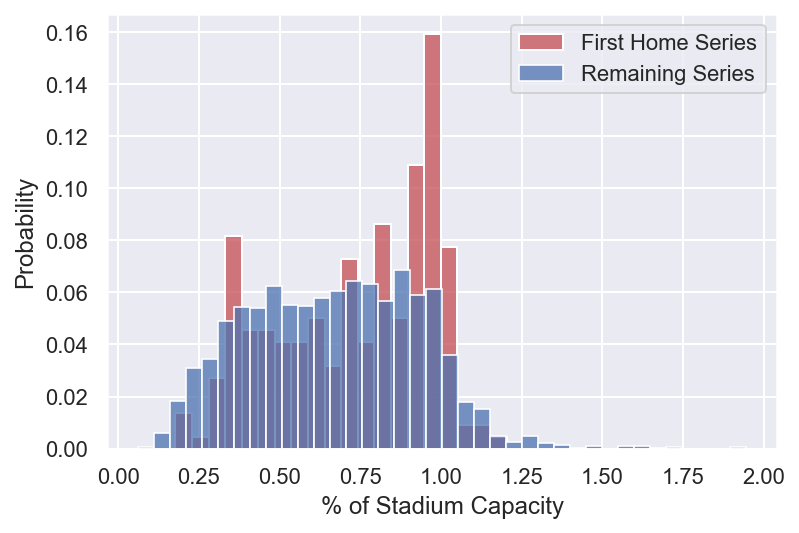

In [845]:
all_features_fs = all_features.merge(home_series2, left_on = ['team_game_x', 'team_ID_x'], right_on = ['team_game', 'team_ID'], how = 'left')
all_features_fs
all_features_fs['first_series'] = all_features_fs['team_game_y'].notna().astype(int)

sns.histplot(data = all_features_fs[all_features_fs['first_series'] == 1], x= 'pct_cap', stat = 'probability', color = 'r', bins = 20)
sns.histplot(data = all_features_fs[all_features_fs['first_series'] == 0], x= 'pct_cap', stat = 'probability')
plt.legend(['First Home Series', 'Remaining Series'])
plt.xlabel('% of Stadium Capacity');

plt.savefig("/Users/philliprichardson/Metis/Module 2/first_series",bbox_inches='tight')

In [797]:
mask2 = (all_features_fs['homeORvis'] == 1 ) & (all_features_fs['pct_cap']< 1.25) & (all_features_fs['first_series'] == 0 )

all_features_fs = all_features_fs[mask2]


In [798]:
test = all_features_fs[key_feats]

#### Checking multicollinearity and reducting key features

In [800]:
def vif(df_X):
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [869]:
key_feats2 = [ 'Weekend', 'precip',  'night', 
       'avg_runs', 'WL_pct', 'streak',
       'games_back', 'in_div']

# vif(test[key_feats2])

#### Checking pairplot

In [561]:
kf = key_feats2.copy()
kf.append('pct_cap')
test = all_features_fs[kf]

In [873]:
# sns.pairplot(data = all_features_fs[key_feats], corner = True, plot_kws = {'alpha': 0.5})

#### Setting up cross validation

In [809]:
X_inp = all_features_fs[key_feats]
y_inp = all_features_fs['pct_cap']

X, X_test, y, y_test = train_test_split(X_inp, y_inp, test_size=.2, random_state=13)

#### Feature Engineering

In [816]:
X1 = X[key_feats2]
y2 = y ** (1/3)
X2 = X1.copy()
X1_test = X_test[key_feats2]
X2_test = X1_test.copy()

#Testing out interactions and polynomials
X2['night_x_weekend'] = X2['night'] * X2['Weekend']
X2_test['night_x_weekend'] = X2_test['night'] * X2_test['Weekend']

#creating setup for polynomial model
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X1)

X_poly = poly.transform(X_inp[key_feats2])
X_val_poly = poly.transform(X1_test)

#scaling for setting up lasso model
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

X_val_poly_scaled = scaler.transform(X_val_poly)

X_scaled = scaler.transform(X_poly)


In [817]:
lm = LinearRegression()
lm2 = LinearRegression()
lm3 = LinearRegression()
lm4 = LinearRegression()

lr_poly = LinearRegression()


lasso = LassoCV()

In [871]:
# Base Linear Model
lm.fit(X1, y)

# Linear model used to test 1-off interactions and polynomial features
lm3.fit(X2, y)

#Polynomial regression
lr_poly.fit(X_train_poly,y)

#Lasso regularization to pair down coefficients
lasso.fit(X_train_poly_scaled, y)

LassoCV()

#### Running 5-fold CV and comparing models

In [819]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
print('base y \t \t   \t -->', mean(cross_val_score(lm, X1, y, cv=kf, scoring='r2')), ' +/- ',  std(cross_val_score(lm, X1, y, cv=kf, scoring='r2')),
      "\n",'Interaction (y) \t -->', mean(cross_val_score(lm3, X2, y, cv=kf, scoring='r2')), ' +/- ', std(cross_val_score(lm3, X2, y, cv=kf, scoring='r2')),
      "\n",'polynomial (y) \t -->', mean(cross_val_score(lr_poly, X_train_poly, y, cv=kf, scoring='r2')), ' +/- ', std(cross_val_score(lr_poly, X_train_poly, y, cv=kf, scoring='r2')),
      "\n",'lasso (y) \t \t -->', mean(cross_val_score(lasso, X_train_poly_scaled, y, cv=kf, scoring='r2')), ' +/- ',std(cross_val_score(lasso, X_train_poly_scaled, y, cv=kf, scoring='r2')))

base y 	 	   	 --> 0.30939692271678637  +/-  0.04372739466280701 
 Interaction (y) 	 --> 0.3137417764621509  +/-  0.04284279767311771 
 polynomial (y) 	 --> 0.3460110090479868  +/-  0.02718426488760106 
 lasso (y) 	 	 --> 0.35010197071279436  +/-  0.031385489042002515


In [872]:
# list(zip((poly.get_feature_names(key_feats2)),lasso.coef_))

preds = lasso.predict(X_scaled)

#### Checking Actuals vs. Predicted on complete data

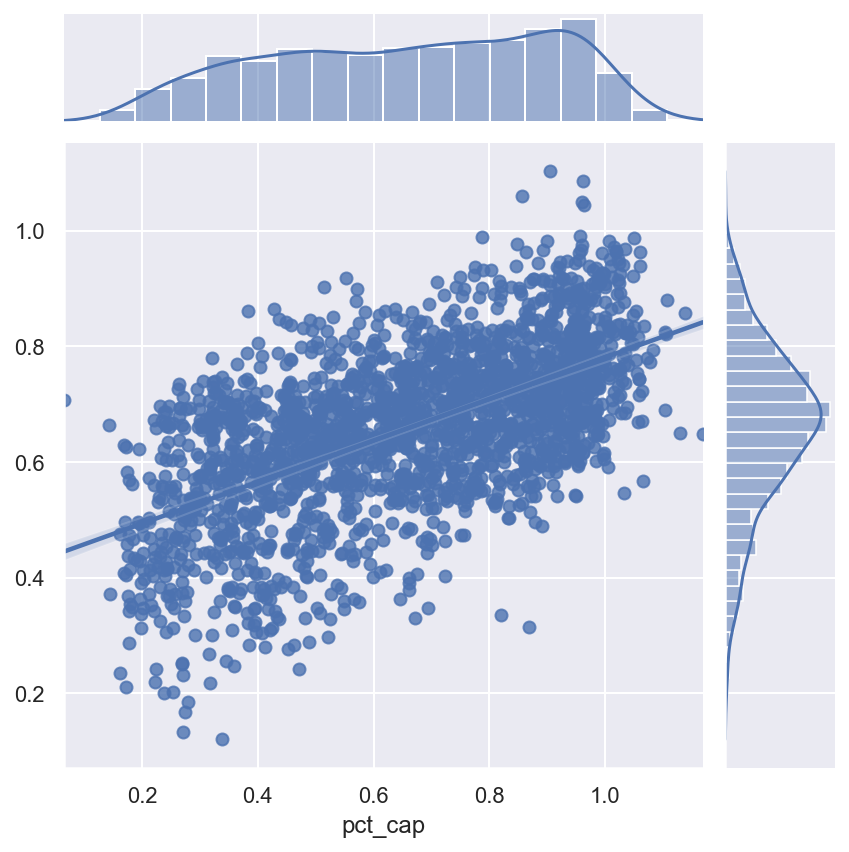

In [860]:
preds = lasso.predict(X_scaled)
g = sns.jointplot(y=preds,x=y_inp,kind = 'reg');
g.set_axis_labels('Actual % of Stadium Capacity', 'Predicted % of Stadium Capacity')

plt.savefig("/Users/philliprichardson/Metis/Module 2/act v pred",bbox_inches='tight')

#### Checking Residuals Assumptions

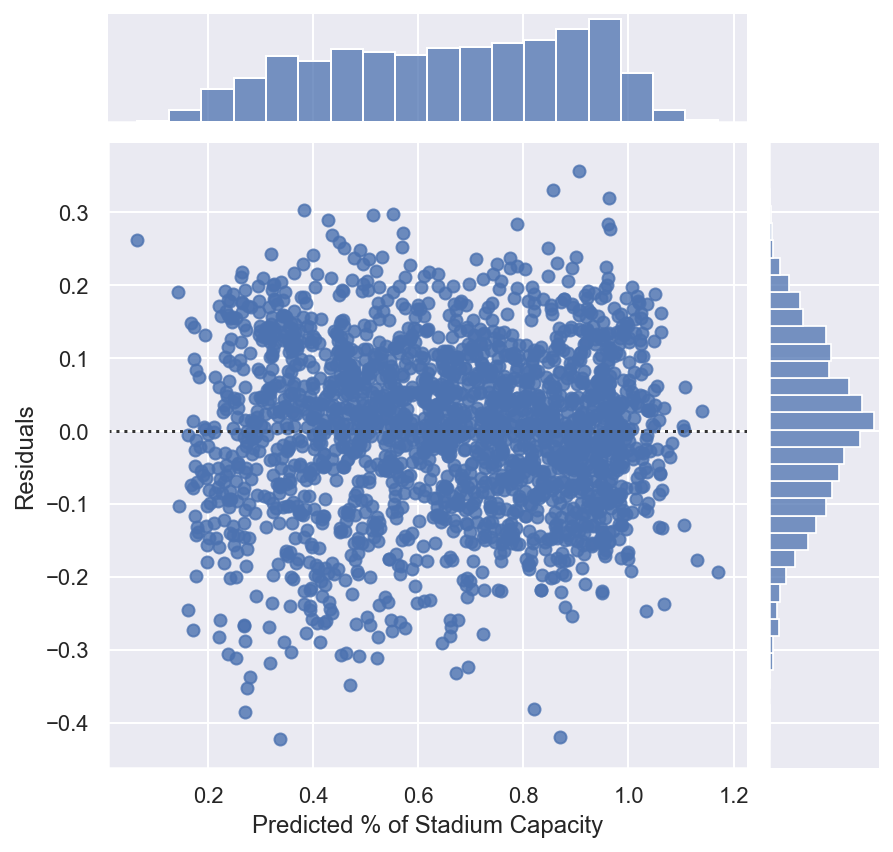

In [868]:
g2 = sns.jointplot(y=preds,x=y_inp,kind = 'resid');
g2.set_axis_labels( 'Predicted % of Stadium Capacity', 'Residuals')
plt.savefig("/Users/philliprichardson/Metis/Module 2/resid",bbox_inches='tight')

#### Checking QQ Plot

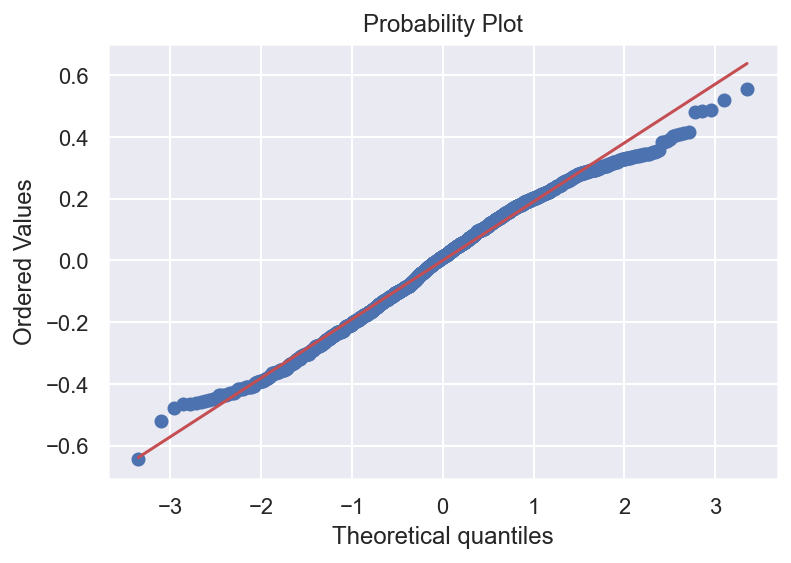

In [858]:
import scipy.stats as stats
stats.probplot(resid, dist="norm", plot=plt)

plt.savefig("/Users/philliprichardson/Metis/Module 2/QQplot",bbox_inches='tight')

#### Lastly checking MAE's

In [875]:
preds3= lasso.predict(X_train_poly_scaled)

def MAE(actuals, preds): #mean absolute error
    return np.mean(np.abs(actuals-preds))


In [874]:
preds2 = lasso.predict(X_val_poly_scaled)
print(MAE(y_inp, preds), MAE(y_test, preds2), MAE(y,preds3))

0.15830881348358244 0.15824652966441793 0.15832438443837357
